# GBDT

## 1.1 Loading Data

In [0]:
import warnings
warnings.filterwarnings("ignore")


import nltk
nltk.download('punkt')
nltk.download('stopwords')
import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/

from nltk.corpus import stopwords

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

 
import pickle

from tqdm import tqdm
import os

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

import warnings
warnings.filterwarnings("ignore")

In [2]:
#import preprocessed data
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
data=pd.read_csv('/content/drive/My Drive/ data_sets/preprocessed_data.csv')
title_data=pd.read_csv("/content/drive/My Drive/ data_sets/train_data.csv")

In [0]:
#preprocessing project title 
# https://stackoverflow.com/a/47091490/4084039

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

# Combining all the above stundents 
 
def preprocess_text(text_data):
    preprocessed_text = []
    # tqdm is for printing the status bar
    for sentance in tqdm(text_data):
        sent = decontracted(sentance)
        sent = sent.replace('\\r', ' ')
        sent = sent.replace('\\n', ' ')
        sent = sent.replace('\\"', ' ')
        sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
        # https://gist.github.com/sebleier/554280
        #sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
        sent=' '.join(token.lower() for token in nltk.word_tokenize(sent) if token.lower() not in stopwords.words('english'))
        preprocessed_text.append(sent.lower().strip())
    return preprocessed_text
preprocessed_titles = preprocess_text(title_data['project_title'].values)

100%|██████████| 109248/109248 [01:22<00:00, 1324.80it/s]


In [0]:
#add project titles to preprocessed data
data['project_title']=preprocessed_titles

#save the concatinated data into drive
df=pd.DataFrame(data)
df.to_csv('data.csv')
!cp data.csv "drive/My Drive/"

In [3]:
data=pd.read_csv("/content/drive/My Drive/data.csv",nrows=20000)
data.head(2)

,Unnamed: 0,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,price,project_title
0,0,ca,mrs,grades_prek_2,53,1,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05,educational support english learners home
1,1,ut,ms,grades_3_5,4,1,specialneeds,specialneeds,imagine 8 9 years old you third grade classroo...,213.03,wanted projector hungry learners


<h2>1.2 Splitting data into Train and cross validation(or test): Stratified Sampling</h2>

In [4]:
# please write all the code with proper documentation, and proper titles for each subsection
# go through documentations and blogs before you start coding
# first figure out what to do, and then think about how to do.
# reading and understanding error messages will be very much helpfull in debugging your code
# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label
y = data['project_is_approved'].values
X = data.drop(['project_is_approved'], axis=1)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y,random_state=42)
#X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train,random_state=42)
print(X_train.shape)
print(X_test.shape)

(16000, 10)
(4000, 10)


<h2>1.3 Make Data Model Ready: encoding eassay, and project_title</h2>

In [5]:
# please write all the code with proper documentation, and proper titles for each subsection
# go through documentations and blogs before you start coding
# first figure out what to do, and then think about how to do.
# reading and understanding error messages will be very much helpfull in debugging your code
# make sure you featurize train and test data separatly

# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label
#TfIdf of words of essay column
tfidf1 = TfidfVectorizer(min_df=10,ngram_range=(1,4), max_features=5000)
tfidf1.fit(X_train['essay'].values)

# we use the fitted TfIdfVectoriser to convert the text to vector
X_train_essay_tfidf = tfidf1.transform(X_train['essay'].values)
X_test_essay_tfidf = tfidf1.transform(X_test['essay'].values)

print("After vectorizations")
print(X_train_essay_tfidf.shape, y_train.shape)
print(X_test_essay_tfidf.shape, y_test.shape)
print("="*100)


After vectorizations
(16000, 5000) (16000,)
(4000, 5000) (4000,)


In [6]:
tfidf2 = TfidfVectorizer(min_df=10,ngram_range=(1,4))
tfidf2.fit(X_train['project_title'].values.astype('U'))

#x = v.fit_transform(df['Review'].values.astype('U'))
# we use the fitted TfIdfVectoriser to convert the text to vector
X_train_title_tfidf = tfidf2.transform(X_train['project_title'].values.astype('U'))
X_test_title_tfidf = tfidf2.transform(X_test['project_title'].values.astype('U'))

print("After vectorizations")
print(X_train_title_tfidf.shape, y_train.shape)
print(X_test_title_tfidf.shape, y_test.shape)
print("="*100)

After vectorizations
(16000, 1183) (16000,)
(4000, 1183) (4000,)


In [0]:
#converting to word to vector
infile = open('/content/drive/My Drive/ data_sets/glove_vectors','rb')
model = pickle.load(infile)
glove_words =  set(model.keys())

In [0]:
#create dictionary of words using essay train
tfidf_model = TfidfVectorizer()
tfidf_model.fit(X_train['essay'])
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words_essay = set(tfidf_model.get_feature_names())

In [9]:
#tfidf vector representation of train essay 
# compute tfidf word2vec for each review.
tfidf_essay_w2v_tr = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_train['essay']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words_essay):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_essay_w2v_tr.append(vector)
print('\n')
print(len(tfidf_essay_w2v_tr))
print(len(tfidf_essay_w2v_tr[0]))

100%|██████████| 16000/16000 [00:30<00:00, 517.53it/s]



16000
300


In [10]:
#tfidf vector representation of test essay 
# compute tfidf word2vec for each review.
tfidf_essay_w2v_te = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_test['essay']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words_essay):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_essay_w2v_te.append(vector)
print('\n')
print(len(tfidf_essay_w2v_te))
print(len(tfidf_essay_w2v_te[0]))

100%|██████████| 4000/4000 [00:07<00:00, 523.17it/s]



4000
300


In [0]:
#create dictionary of words using title train
tfidf_model1 = TfidfVectorizer()
tfidf_model1.fit(X_train['project_title'].astype('U'))
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model1.get_feature_names(), list(tfidf_model1.idf_)))
tfidf_words_title = set(tfidf_model1.get_feature_names())

In [12]:
#tfidf vector representation of test title
# compute tfidf word2vec for each review.
tfidf_title_w2v_tr = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_train['project_title']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in str(sentence).split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words_title):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_title_w2v_tr.append(vector)

print('\n')
print(len(tfidf_title_w2v_tr))
print(len(tfidf_title_w2v_tr[0]))

100%|██████████| 16000/16000 [00:00<00:00, 31569.16it/s]



16000
300


In [13]:
#tfidf vector representation of test title
# compute tfidf word2vec for each review.
tfidf_title_w2v_te = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_test['project_title']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in str(sentence).split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words_title):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_title_w2v_te.append(vector)

print('\n')
print(len(tfidf_title_w2v_te))
print(len(tfidf_title_w2v_te[0]))

100%|██████████| 4000/4000 [00:00<00:00, 21618.17it/s]




4000
300


In [14]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

nltk.download('vader_lexicon')

sid = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [15]:
ss_train=[]
for i in tqdm(X_train['essay']):
  ss=sid.polarity_scores(i)
  ss_train.append(ss)

ss_test=[]
for i in tqdm(X_test['essay']):
  ss=sid.polarity_scores(i)
  ss_test.append(ss)

100%|██████████| 4000/4000 [00:07<00:00, 550.08it/s]


In [16]:
s_tr1=[]
s_tr2=[]
s_tr3=[]
s_tr4=[]
for i in tqdm(ss_train):
  s_tr1.append([i['neg']])
  s_tr2.append([i['pos']])
  s_tr3.append([i['neu']])
  s_tr4.append([i['compound']])

s_te1=[]
s_te2=[]
s_te3=[]
s_te4=[]
for i in tqdm(ss_test):
  s_te1.append([i['neg']])
  s_te2.append([i['pos']])
  s_te3.append([i['neu']])
  s_te4.append([i['compound']])

100%|██████████| 4000/4000 [00:00<00:00, 668042.37it/s]


<h2>1.4 Make Data Model Ready: encoding numerical, categorical features</h2>

In [0]:
# please write all the code with proper documentation, and proper titles for each subsection
# go through documentations and blogs before you start coding 
# first figure out what to do, and then think about how to do.
# reading and understanding error messages will be very much helpfull in debugging your code
# make sure you featurize train and test data separatly

# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label
def responce_coding(train,test):
    t_dt=dict(train.value_counts())#dictionary of total X_train
    t_dp=dict(train.loc[y_train==1].value_counts())#dictionary of X-train with positive output
    
    
    l_train=[[t_dp[i]/t_dt[i]] if i in t_dp.keys() else [0] for i in train]
    l_test=[[t_dp[i]/t_dt[i]] if i in t_dp.keys() else [0.5] for i in test]#if a key is not present in test append 0.5
    
    return l_train,l_test

# responce coding on teacher prefix
X_train_teacher,X_test_teacher = responce_coding(X_train['teacher_prefix'],X_test['teacher_prefix'])


# responce coding on school state
X_train_state,X_test_state = responce_coding(X_train['school_state'],X_test['school_state'])


#responce coding  on project grade category
X_train_grade,X_test_grade = responce_coding(X_train['project_grade_category'],X_test['project_grade_category'])


#responce coding on on clean categories
X_train_categories,X_test_categories = responce_coding(X_train['clean_categories'],X_test['clean_categories'])


In [0]:
#normalize number of previously posted projects of the project
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
normalizer.fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))

X_train_previous = normalizer.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(1,-1)).reshape(-1,1)
X_test_previous = normalizer.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(1,-1)).reshape(-1,1)

 

#normalize prize of the project
normalizer1 = Normalizer()
normalizer.fit(X_train['price'].values.reshape(1,-1))

X_train_price_norm = normalizer1.transform(X_train['price'].values.reshape(1,-1)).reshape(-1,1)
X_test_price_norm = normalizer1.transform(X_test['price'].values.reshape(1,-1)).reshape(-1,1)


## Concatinating all the features

In [19]:
from scipy.sparse import hstack
#concatinate tfidf features
X_tr_tfidf = hstack((X_train_essay_tfidf,X_train_title_tfidf, X_train_state, X_train_teacher, X_train_grade, X_train_price_norm,X_train_previous,X_train_categories ,X_train_state,s_tr1,s_tr2,s_tr3,s_tr4)).tocsr()
X_te_tfidf = hstack((X_test_essay_tfidf,X_test_title_tfidf,X_test_state, X_test_teacher, X_test_grade, X_test_price_norm,X_test_previous,X_test_categories,X_test_state,s_te1,s_te2,s_te3,s_te4)).tocsr() 

print("Final TfIdf Data matrix")
print(X_tr_tfidf.shape, y_train.shape)
print(X_te_tfidf.shape, y_test.shape)
print("="*100)

Final TfIdf Data matrix
(16000, 6194) (16000,)
(4000, 6194) (4000,)


In [20]:
#concatinate word to vector  features
X_tr_w2v= np.hstack([tfidf_essay_w2v_tr,tfidf_title_w2v_tr,X_train_state, X_train_teacher, X_train_grade,X_train_price_norm,X_train_previous,X_train_categories ,X_train_state,s_tr1,s_tr2,s_tr3,s_tr4])
X_te_w2v= np.hstack([tfidf_essay_w2v_te,tfidf_title_w2v_te,X_test_state, X_test_teacher, X_test_grade, X_test_price_norm,X_test_previous,X_test_categories,X_test_state,s_te1,s_te2,s_te3,s_te4])

print("Final W2V Data matrix")
print(X_tr_w2v.shape, y_train.shape)
print(X_te_w2v.shape, y_test.shape)
print("="*100)

Final W2V Data matrix
(16000, 611) (16000,)
(4000, 611) (4000,)


<h2>1.5 Appling Models on different kind of featurization as mentioned in the instructions</h2>

<br>Apply GBDT on different kind of featurization as mentioned in the instructions
<br> For Every model that you work on make sure you do the step 2 and step 3 of instrucations

In [0]:
# please write all the code with proper documentation, and proper titles for each subsection
# go through documentations and blogs before you start coding
# first figure out what to do, and then think about how to do.
# reading and understanding error messages will be very much helpfull in debugging your code
# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
# fit model no training data
model = XGBClassifier()
parameters = {'n_estimators':[50, 100,150, 200],'max_depth':[1, 2, 8, 12]}

In [22]:
clf_t = GridSearchCV(model, parameters,cv=5,scoring='roc_auc',return_train_score=True)
clf_t.fit(X_tr_tfidf,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': [1, 2, 8, 12],
                         'n_estimators': [50, 100, 150, 200]},
             pre_dispatch='2*n_jobs', refit=True, return_trai

In [0]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics

def matrix(l):#function to prepare AUC matrix for plotting 
    a=[]
    for i in range(4):
        b=[]
        for j in range(i*4,(i+1)*4):
            b.append(l[j])
        a.append(b)
    return(a)

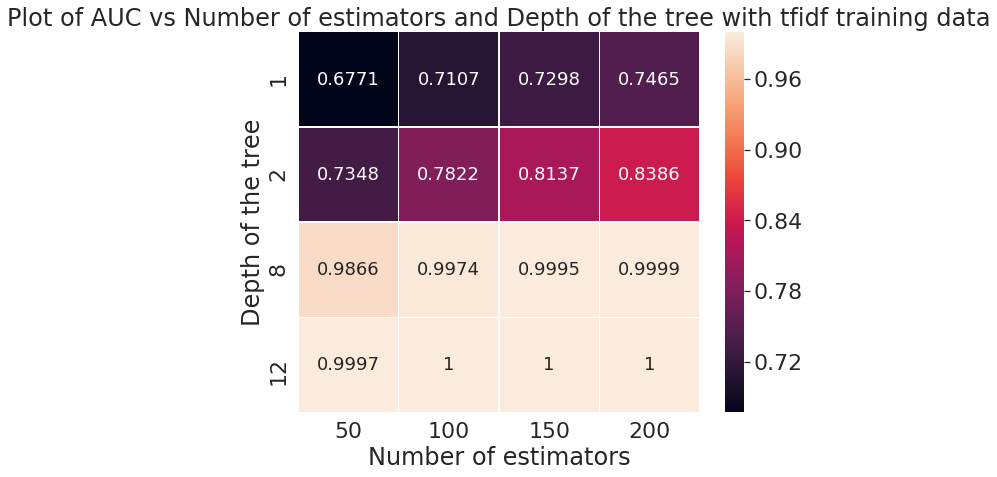

In [45]:
import seaborn as sns
df = pd.DataFrame(matrix(clf_t.cv_results_['mean_train_score']),parameters['max_depth'],parameters['n_estimators'])
plt.figure(figsize=(9,7))
sns.set(font_scale=2) # for label size
sns.heatmap(df, annot=True, annot_kws={"size": 18,},fmt='.4g', linewidths=.3) # font size
plt.xlabel('Number of estimators')
plt.ylabel('Depth of the tree')
plt.title('Plot of AUC vs Number of estimators and Depth of the tree with tfidf training data')

plt.show()

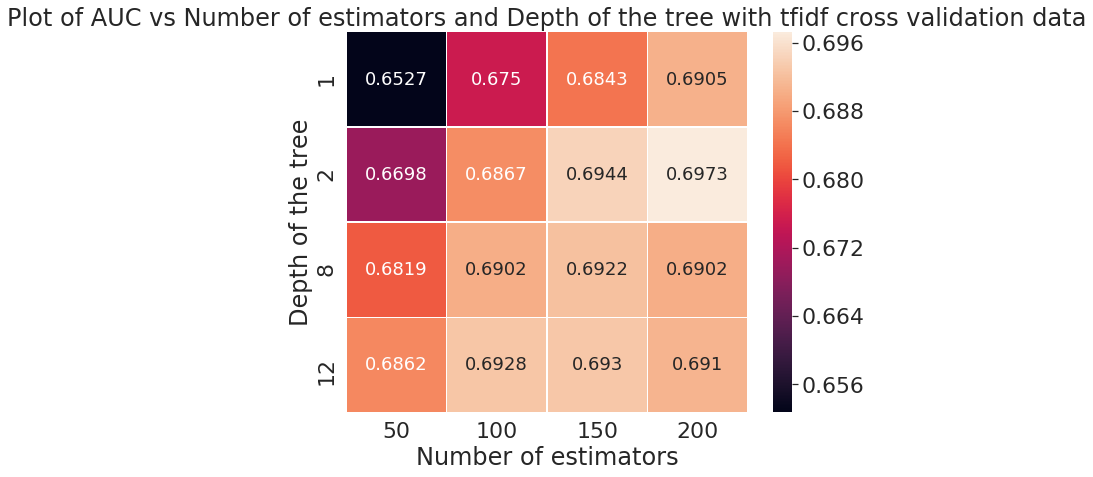

Best Hyper parameters:  {'max_depth': 2, 'n_estimators': 200}


In [46]:
df= pd.DataFrame(matrix(clf_t.cv_results_['mean_test_score']),parameters['max_depth'],parameters['n_estimators'])
plt.figure(figsize=(9,7))
sns.set(font_scale=2) # for label size
sns.heatmap(df, annot=True, annot_kws={"size": 18,},fmt='.4g', linewidths=.3) # font size
plt.xlabel('Number of estimators')
plt.ylabel('Depth of the tree')
plt.title('Plot of AUC vs Number of estimators and Depth of the tree with tfidf cross validation data')

plt.show()

print("Best Hyper parameters: ",clf_t.best_params_)

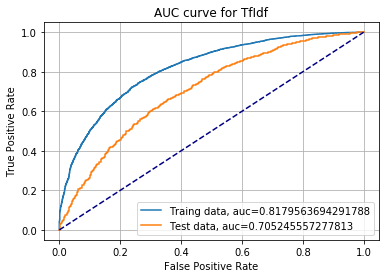

In [24]:
Tr_pred=[i[1] for i in clf_t.predict_proba(X_tr_tfidf)]
Test_pred=[i[1] for i in clf_t.predict_proba(X_te_tfidf)]

fpr, tpr, _ = metrics.roc_curve(y_train,  Tr_pred)
auc = metrics.roc_auc_score(y_train, Tr_pred)
plt.plot(fpr,tpr,label="Traing data, auc="+str(auc))

fpr, tpr, _ = metrics.roc_curve(y_test,  Test_pred)
auc_t = metrics.roc_auc_score(y_test, Test_pred)
plt.plot(fpr,tpr,label="Test data, auc="+str(auc_t))
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC curve for TfIdf')
plt.grid()
plt.legend()
plt.show()

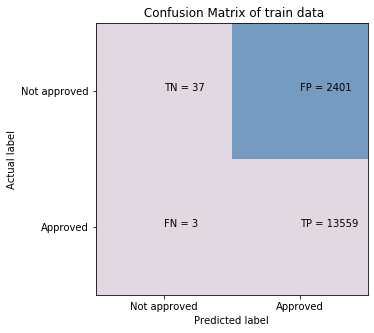

In [25]:
plt.figure(figsize=(10,5))
cm = confusion_matrix(y_train,clf_t.predict(X_tr_tfidf))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.twilight)
classNames = ['Not approved','Approved']
plt.title(' Confusion Matrix of train data')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=0)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()

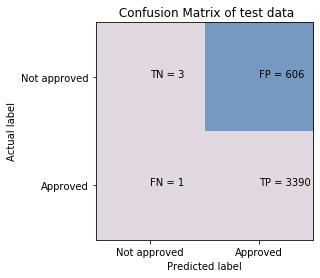

In [26]:
cm = confusion_matrix(y_test,clf_t.predict(X_te_tfidf))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.twilight)
classNames = ['Not approved','Approved']
plt.title(' Confusion Matrix of test data')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=0)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()

## Word to vector

In [29]:
clf_w = GridSearchCV(model, parameters,cv=5,scoring='roc_auc',return_train_score=True)
clf_w.fit(X_tr_w2v,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': [1, 2, 8, 12],
                         'n_estimators': [50, 100, 150, 200]},
             pre_dispatch='2*n_jobs', refit=True, return_trai

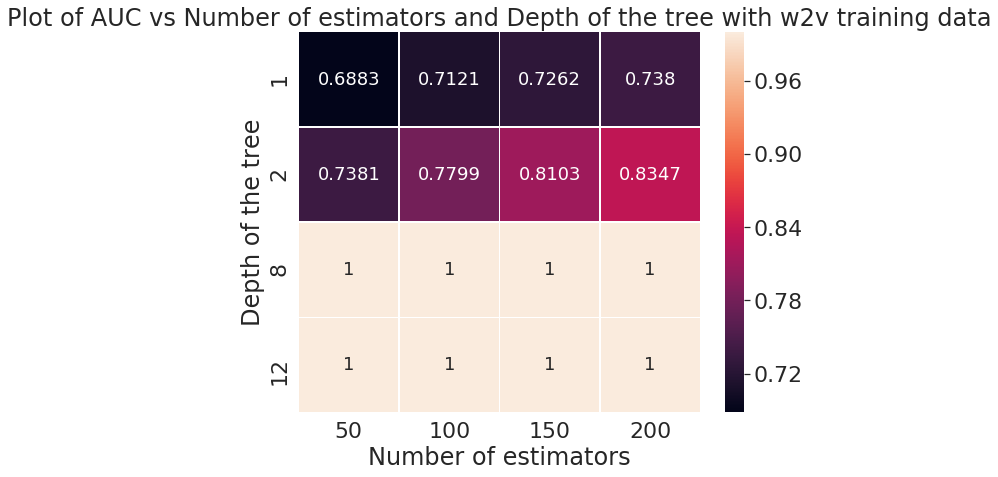

In [47]:
df= pd.DataFrame(matrix(clf_w.cv_results_['mean_train_score']),parameters['max_depth'],parameters['n_estimators'])
plt.figure(figsize=(9,7))
sns.set(font_scale=2) # for label size
sns.heatmap(df, annot=True, annot_kws={"size": 18,},fmt='.4g', linewidths=.3) # font size
plt.xlabel('Number of estimators')
plt.ylabel('Depth of the tree')
plt.title('Plot of AUC vs Number of estimators and Depth of the tree with w2v training data')

plt.show()

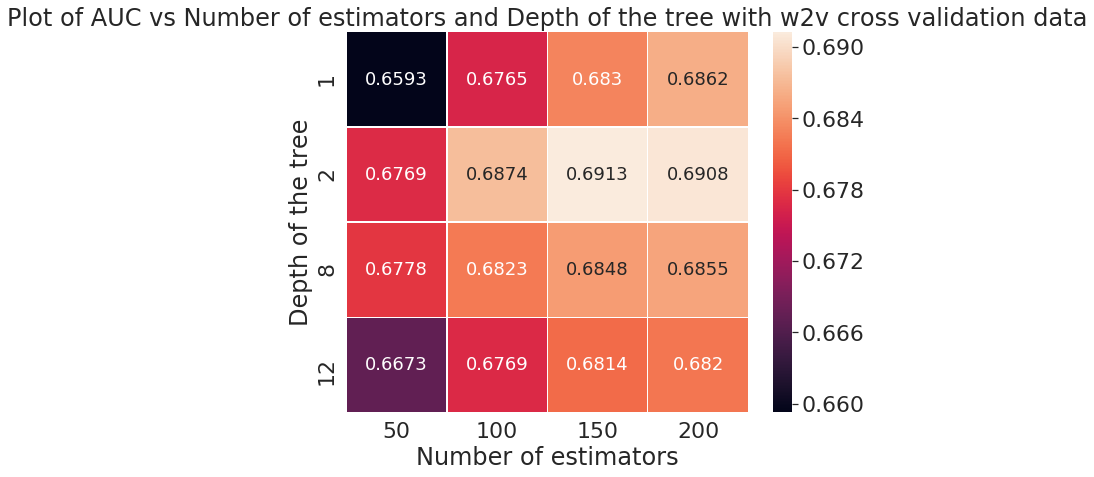

Best Hyper parameters:  {'max_depth': 2, 'n_estimators': 150}


In [42]:
df= pd.DataFrame(matrix(clf_w.cv_results_['mean_test_score']),parameters['max_depth'],parameters['n_estimators'])
plt.figure(figsize=(9,7))
sns.set(font_scale=2) # for label size
sns.heatmap(df, annot=True, annot_kws={"size": 18,},fmt='.4g', linewidths=.3) # font size
plt.xlabel('Number of estimators')
plt.ylabel('Depth of the tree')
plt.title('Plot of AUC vs Number of estimators and Depth of the tree with w2v cross validation data')

plt.show()

print("Best Hyper parameters: ",clf_w.best_params_)

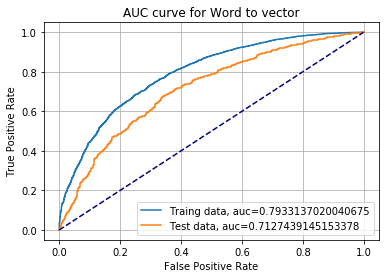

In [30]:
Tr_pred=[i[1] for i in clf_w.predict_proba(X_tr_w2v)]
Test_pred=[i[1] for i in clf_w.predict_proba(X_te_w2v)]

fpr, tpr, _ = metrics.roc_curve(y_train,  Tr_pred)
auc = metrics.roc_auc_score(y_train, Tr_pred)
plt.plot(fpr,tpr,label="Traing data, auc="+str(auc))

fpr, tpr, _ = metrics.roc_curve(y_test,  Test_pred)
auc_w = metrics.roc_auc_score(y_test, Test_pred)
plt.plot(fpr,tpr,label="Test data, auc="+str(auc_w))
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC curve for Word to vector')
plt.legend()
plt.grid()
plt.show()

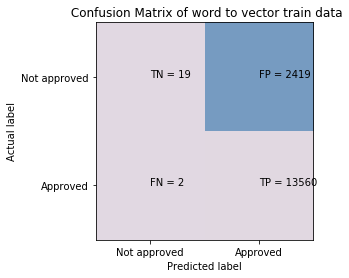

In [31]:
cm = confusion_matrix(y_train,clf_w.predict(X_tr_w2v))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.twilight)
classNames = ['Not approved','Approved']
plt.title(' Confusion Matrix of word to vector train data')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=0)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()

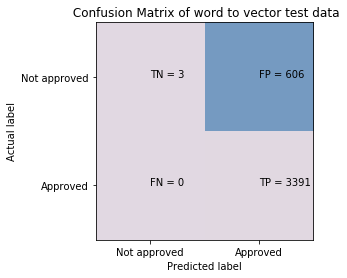

In [32]:
cm = confusion_matrix(y_test,clf_w.predict(X_te_w2v))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.twilight)
classNames = ['Not approved','Approved']
plt.title(' Confusion Matrix of word to vector test data')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=0)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()

<h1>3. Summary</h1>

<br> as mentioned in the step 4 of instructions

In [36]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Vectorizer", "Model", "Hyper Parameter", "AUC"]

x.add_row(["TfIdf", 'clf_t', clf_t.best_params_, round(auc_t,4)])
x.add_row(["TfIdf Word to Vec",'clf_w',clf_w.best_params_, round(auc_w,4)])
 
print(x)

+-------------------+-------+---------------------------------------+--------+
|     Vectorizer    | Model |            Hyper Parameter            |  AUC   |
+-------------------+-------+---------------------------------------+--------+
|       TfIdf       | clf_t | {'max_depth': 2, 'n_estimators': 200} | 0.7052 |
| TfIdf Word to Vec | clf_w | {'max_depth': 2, 'n_estimators': 150} | 0.7127 |
+-------------------+-------+---------------------------------------+--------+
